# Bayesian Ridge Regression - Technical Indicators

# References 

* http://www.machinelearning.org/proceedings/icml2004/papers/354.pdf
* http://blog.applied.ai/bayesian-inference-with-pymc3-part-2/

In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

%load_ext version_information
%version_information matplotlib, numpy, pandas, pymc3, seaborn, sklearn

Software versions
Python 3.5.1 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython 4.1.2
OS Linux 3.13.0 86 generic x86_64 with debian jessie sid
matplotlib 1.5.1
numpy 1.10.4
pandas 0.18.0
pymc3 3.0
seaborn 0.7.0
sklearn 0.17.1
Wed May 25 10:03:57 2016 BST

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.plotly as py
import plotly.graph_objs as go 
import pymc3 as pm
import random
import seaborn as sns
from sklearn import preprocessing as preproc
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error as mse, accuracy_score as acc_scr, mean_absolute_error as mae

np.set_printoptions(threshold=np.nan)
sns.set()

In [4]:
def directional_symmetry(act, pred):
    act_ticks = list(map(lambda x: 1 if x >= 0 else 0, act.values))
    pred_ticks = list(map(lambda x: 1 if x >= 0 else 0, pred))
    d = list(map(lambda t: t[0] == t[1], zip(act_ticks, pred_ticks)))
    
    return np.sum(d) / len(act_ticks)

In [9]:
path = '../btc-data/BTC_Trades_techind_30s.csv'
data30s = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_Trades_techind_60s.csv'
data1m = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_Trades_techind_300s.csv'
data5m = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_Trades_techind_600s.csv'
data10m = pd.read_csv(path, index_col = 0, parse_dates = True)

# Data Preprocessing

In [6]:
def evaluate(data):
    
    X, y = data, data['DELTAP'].copy()
        
    train_dates = X.index[:int(0.7*len(X))]
    test_dates = X.index[int(0.7*len(X)):]

    print('First training date: ', train_dates[0])
    print('Last training date: ', train_dates[-1])
    print('First testing date: ', test_dates[0])
    print('Last testing date: ', test_dates[-1])

    # Create DataFrames for the training set. Input: mid prices from the previous hour, output: mid price change in the next 10 seconds.

    X_train = X[train_dates[0]:train_dates[-1]].drop(['Price', 'DELTAP'], axis = 1)
    y_train = y[train_dates[0]:train_dates[-1]]
    
    X_test = X[test_dates[0]:test_dates[-1]].drop(['Price', 'DELTAP'], axis = 1)
    y_test = y[test_dates[0]:test_dates[-1]]
    
    scaler = preproc.StandardScaler()
    for df in X_train.columns.tolist():
        scaler.fit(X_train[df].reshape(-1,1))
        X_train[df] = scaler.transform(X_train[df].reshape(-1,1))
        X_test[df] = scaler.transform(X_test[df].reshape(-1,1))

    clf = BayesianRidge(compute_score=True)
    clf.fit(X_train, y_train)

    plt.figure(figsize=(20, 10))
    plt.title("Weights of the previous prices")
    plt.plot(clf.coef_)
    plt.xlabel("Prices")
    plt.ylabel("Weights")
    
    selected = list(map(lambda t: t[0],
                       (filter(lambda t: np.abs(t[1]) > 0.005, 
                       zip(X_train.columns, clf.coef_)))))

    pred = clf.predict(X_test)
    pd.DataFrame(pred, index = test_dates)

    plt.figure(figsize = (20,10))
    plt.title('Prediction with previous 360 prices')
    plt.plot(y_test.index, y_test, label = 'Actual Prices')
    plt.plot(y_test.index, pred, label = 'Predicted Prices')
    plt.legend()

    plt.figure(figsize = (20,10))
    plt.title('Zoom in')
    plt.plot(y_test.index, y_test, label = 'Actual Prices')
    plt.plot(y_test.index, pred, label = 'Predicted Prices')
    plt.xlim('2016-04-08 00', '2016-04-10 00')
    plt.legend()
    
    print('\n\nResults of prediction with all the technical indicators')
    print('===========================================================\n')
    R2_test = clf.score(X_test, y_test)
    R2_train = clf.score(X_train, y_train)
    print('Training set R2: ', R2_train, ', Test set R2: ', R2_test)
    rmse_test = np.sqrt(mse(y_test, pred))
    rmse_train = np.sqrt(mse(y_train, clf.predict(X_train)))
    print('Training set RMSE: ', rmse_train, ', Test set RMSE: ', rmse_test)
    mae_test = mae(y_test, pred)
    mae_train = mae(y_train, clf.predict(X_train))
    print('Training set MAE: ', mae_train, ', Test set MAE: ', mae_test)
    print('Directional Symmetry: ', directional_symmetry(y_test, pred), '\n')
    print('===========================================================\n\n')
    print(selected, '\n\n')
    
    X_train = X[selected][train_dates[0]:train_dates[-1]]
    y_train = y[train_dates[0]:train_dates[-1]]

    clf = BayesianRidge(compute_score=True)
    clf.fit(X_train, y_train)

    plt.figure(figsize=(20, 10))
    plt.title("Weights of the previous prices")
    plt.plot(clf.coef_)
    plt.xlabel("Prices")
    plt.ylabel("Weights")

    X_test = X[selected][test_dates[0]:test_dates[-1]]
    y_test = y[test_dates[0]:test_dates[-1]]

    pred = clf.predict(X_test)
    pd.DataFrame(pred, index = test_dates)

    plt.figure(figsize = (20,10))
    plt.title('Prediction with previous 360 prices')
    plt.plot(y_test.index, y_test, label = 'Actual Prices')
    plt.plot(y_test.index, pred, label = 'Predicted Prices')
    plt.legend()

    plt.figure(figsize = (20,10))
    plt.title('Zoom in')
    plt.plot(y_test.index, y_test, label = 'Actual Prices')
    plt.plot(y_test.index, pred, label = 'Predicted Prices')
    plt.xlim('2016-04-08 00', '2016-04-10 00')
    plt.legend()
    
    print('\n\nResults of prediction with selected technical indicators')
    print('============================================================\n')
    R2_test = clf.score(X_test, y_test)
    R2_train = clf.score(X_train, y_train)
    print('Training set R2: ', R2_train, ', Test set R2: ', R2_test)
    rmse_test = np.sqrt(mse(y_test, pred))
    rmse_train = np.sqrt(mse(y_train, clf.predict(X_train)))
    print('Training set RMSE: ', rmse_train, ', Test set RMSE: ', rmse_test)
    mae_test = mae(y_test, pred)
    mae_train = mae(y_train, clf.predict(X_train))
    print('Training set MAE: ', mae_train, ', Test set MAE: ', mae_test)
    print('Directional Symmetry: ', directional_symmetry(y_test, pred), '\n')
    print('============================================================\n\n')

First training date:  2016-02-02 06:58:38
Last training date:  2016-03-30 22:28:38
First testing date:  2016-03-30 22:29:08
Last testing date:  2016-04-24 15:25:08


Results of prediction with all the technical indicators

Training set R2:  0.0827431835995 , Test set R2:  0.113953768092
Training set RMSE:  0.319798101168 , Test set RMSE:  0.255927309929
Training set MAE:  0.183599999185 , Test set MAE:  0.156056136776
Directional Symmetry:  0.540595617894 



['K360', 'K180', 'K60', 'D180', 'D60', 'sD180', 'sD60', 'MOM60', 'ROC60', 'LWR360', 'LWR180', 'LWR60', 'ADOSC360', 'ADOSC60', 'DISP360', 'DISP180', 'DISP60', 'OSCP60-180', 'RSI360', 'RSI180', 'RSI60', 'CCI180'] 




Results of prediction with selected technical indicators

Training set R2:  0.0827230577532 , Test set R2:  0.11384691474
Training set RMSE:  0.319801609549 , Test set RMSE:  0.255942741328
Training set MAE:  0.18362382056 , Test set MAE:  0.156099749882
Directional Symmetry:  0.540750214327 





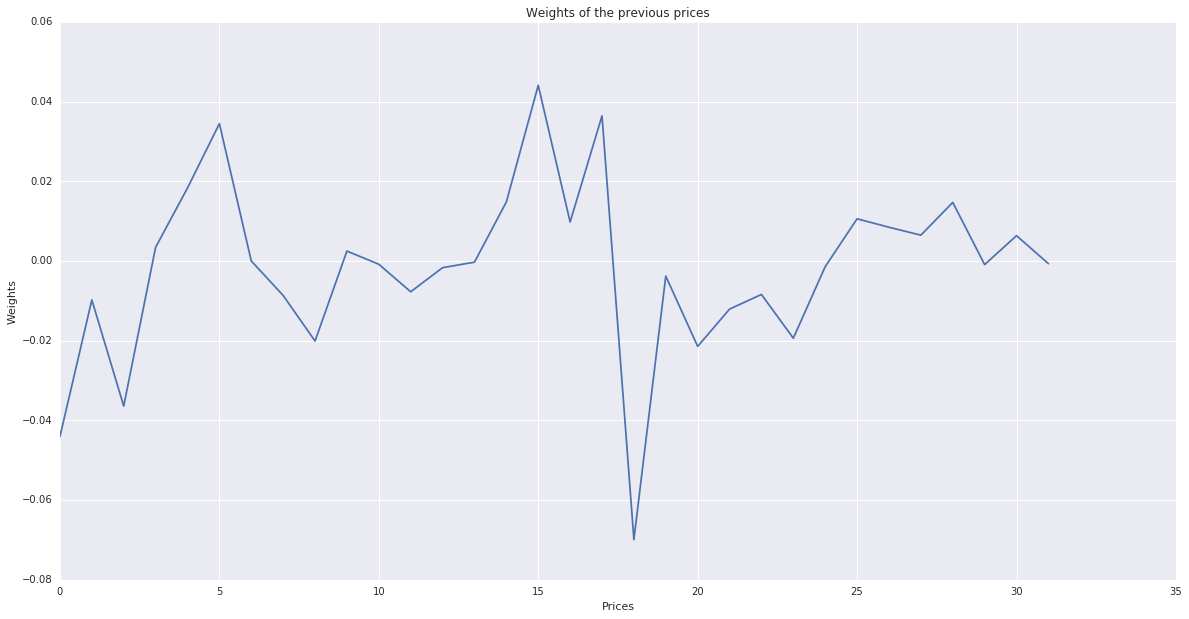

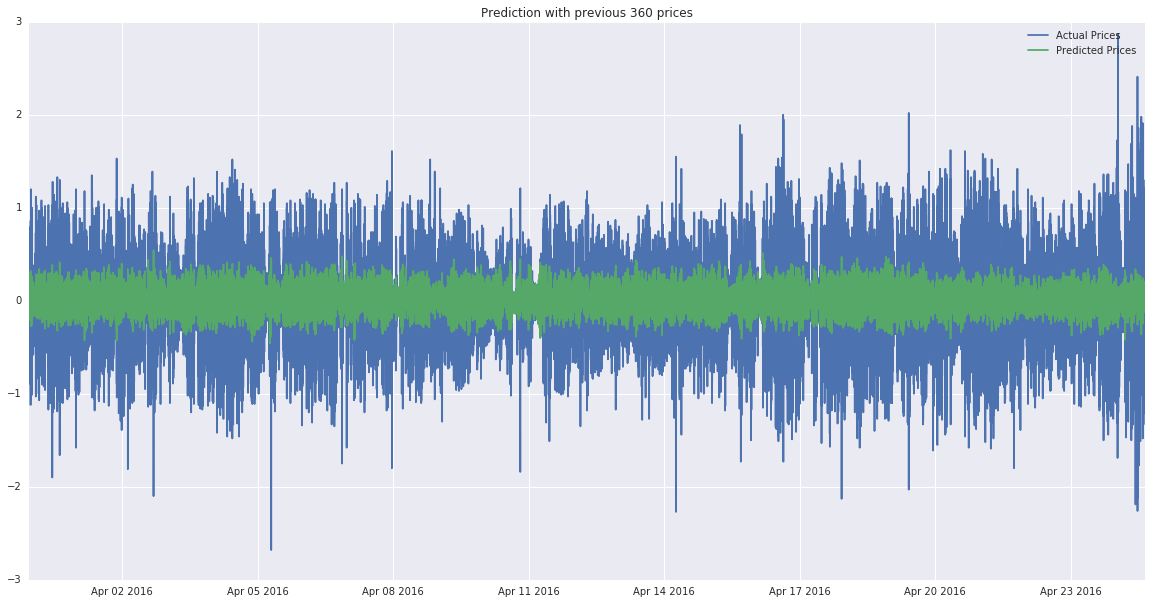

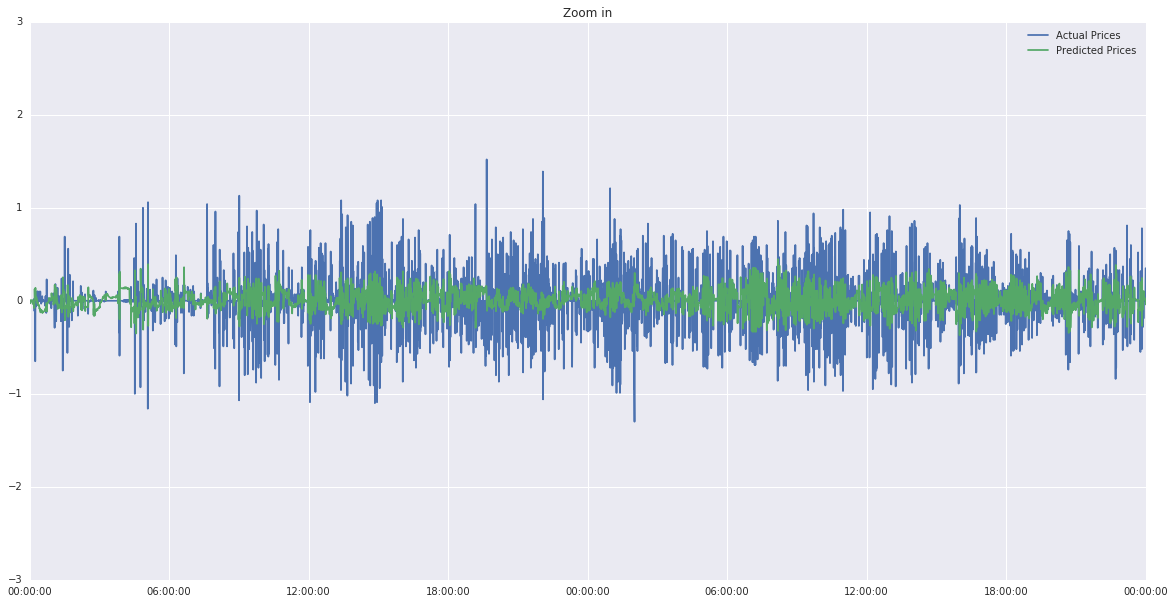

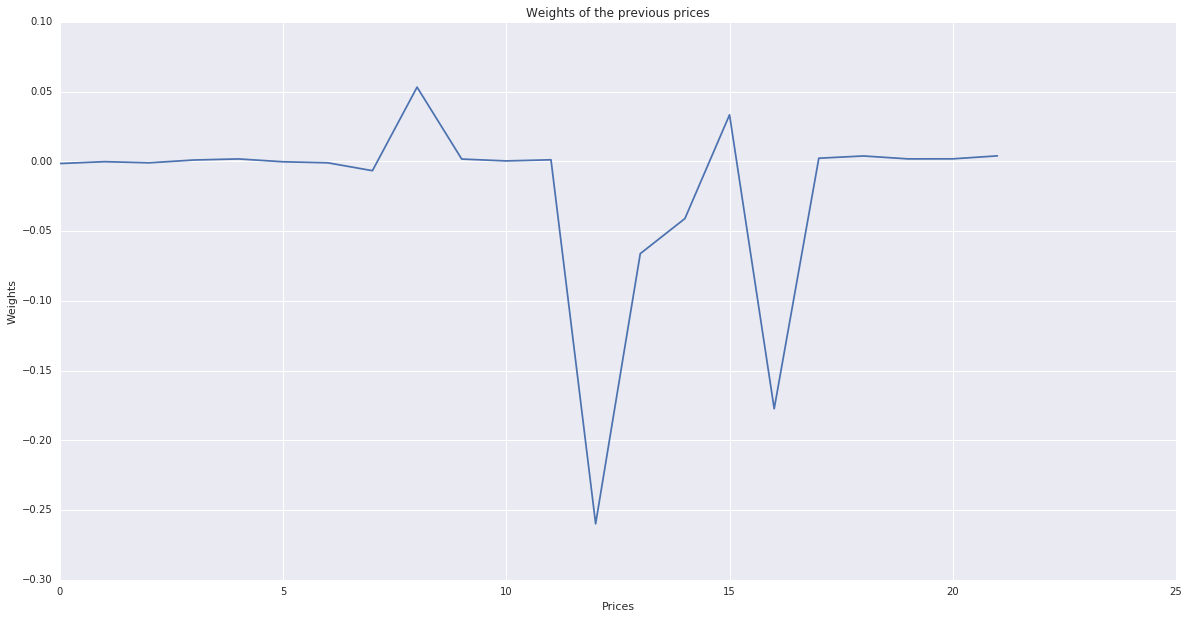

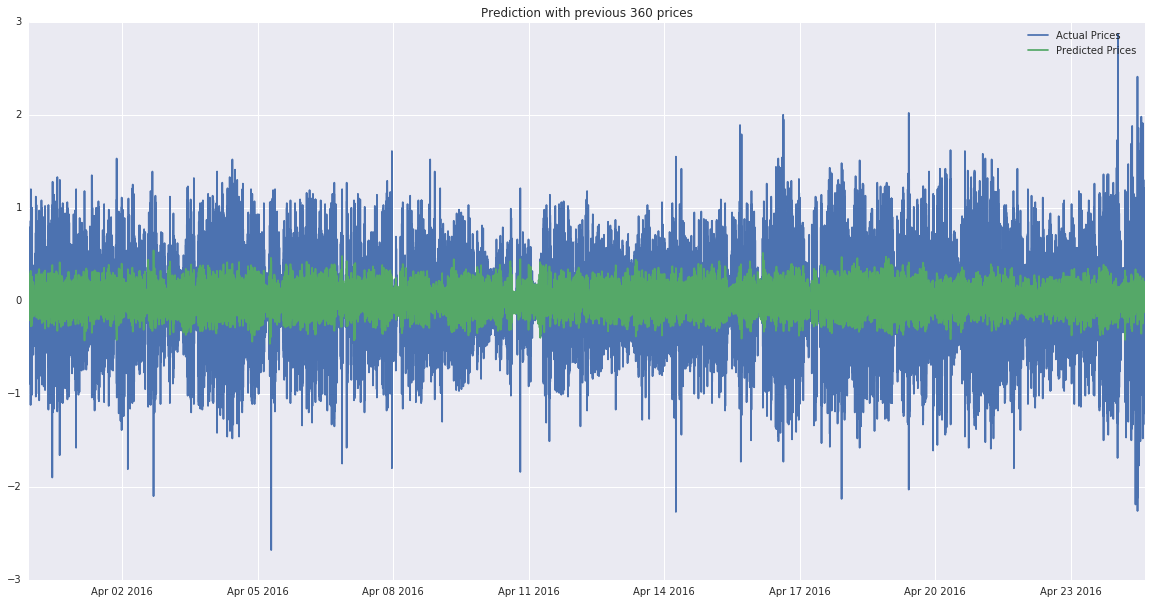

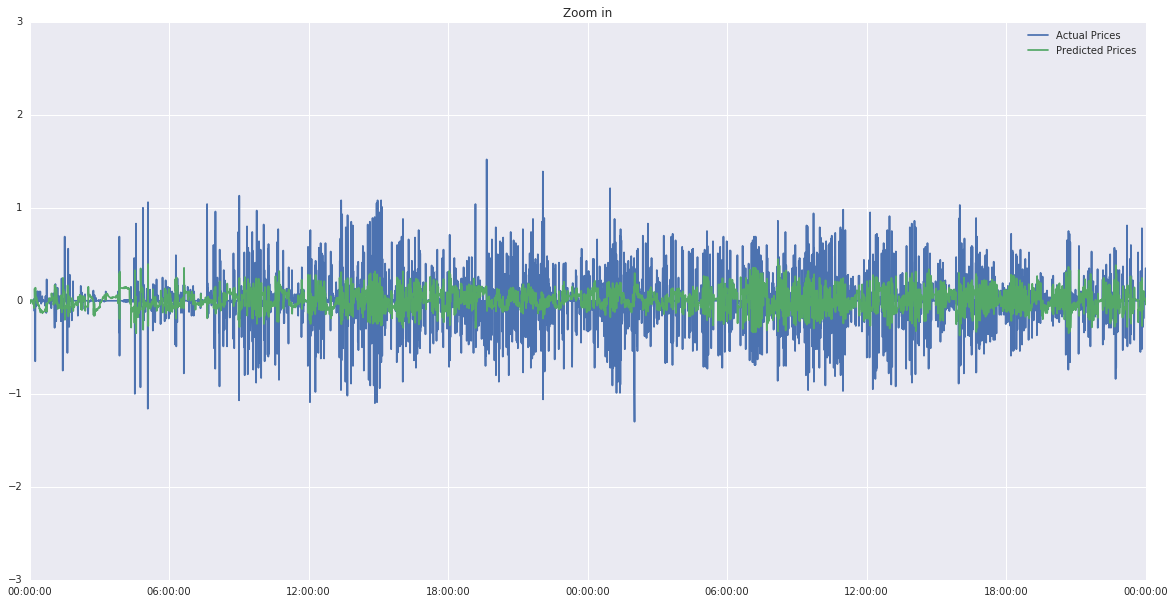

In [10]:
evaluate(data30s.copy())

First training date:  2016-02-02 15:57:38
Last training date:  2016-03-31 01:09:38
First testing date:  2016-03-31 01:10:38
Last testing date:  2016-04-24 15:24:38


Results of prediction with all the technical indicators

Training set R2:  0.101934694942 , Test set R2:  0.126096132416
Training set RMSE:  0.392613292594 , Test set RMSE:  0.309353970471
Training set MAE:  0.248451113127 , Test set MAE:  0.20586777933
Directional Symmetry:  0.570238599464 



['K360', 'K180', 'K60', 'D360', 'D180', 'D60', 'sD180', 'sD60', 'MOM360', 'LWR360', 'LWR180', 'LWR60', 'ADOSC360', 'ADOSC180', 'ADOSC60', 'DISP360', 'DISP180', 'DISP60', 'OSCP180-360', 'OSCP60-180', 'RSI360', 'RSI180', 'RSI60', 'CCI180'] 




Results of prediction with selected technical indicators

Training set R2:  0.101879070274 , Test set R2:  0.126127454933
Training set RMSE:  0.392625451312 , Test set RMSE:  0.309348426479
Training set MAE:  0.248556052549 , Test set MAE:  0.205911189711
Directional Symmetry:  0.570408019201 


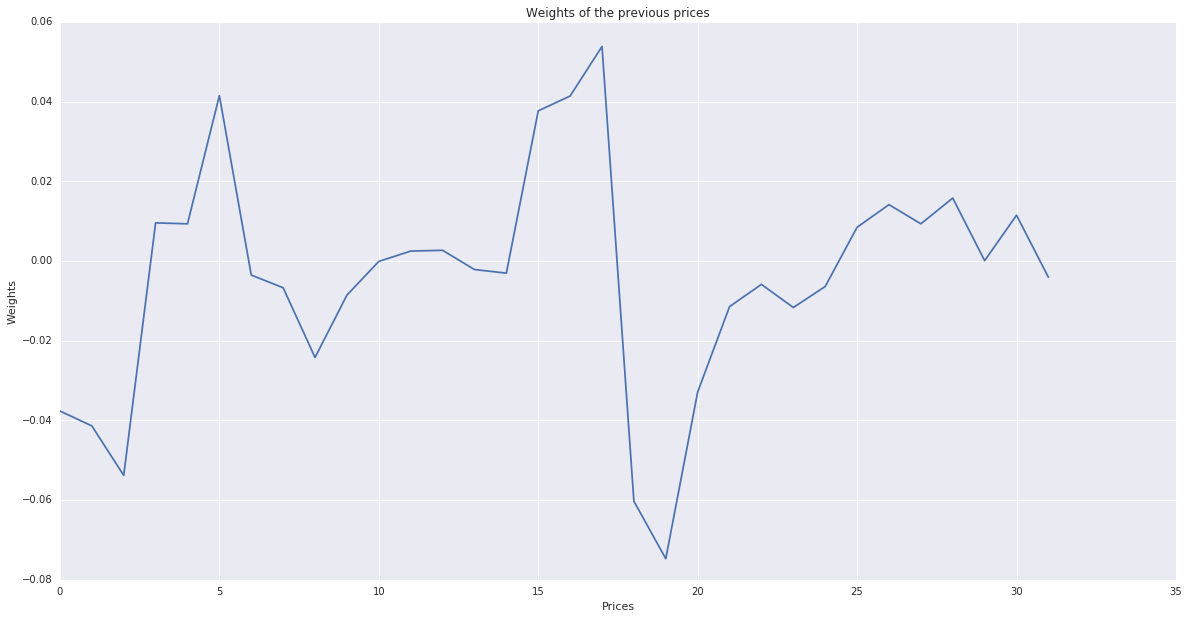

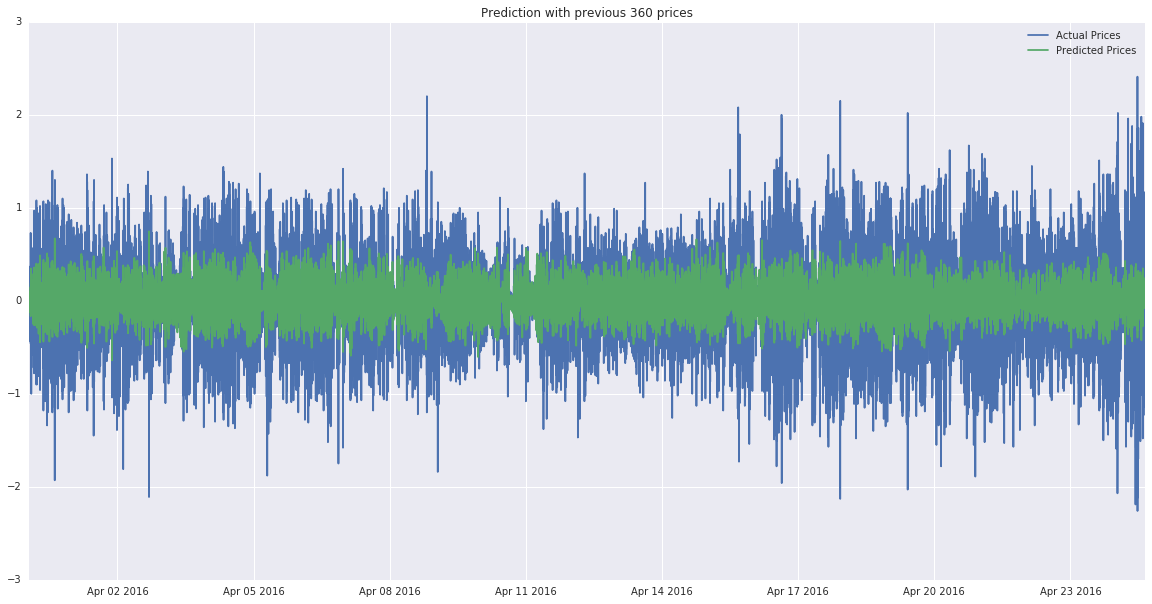

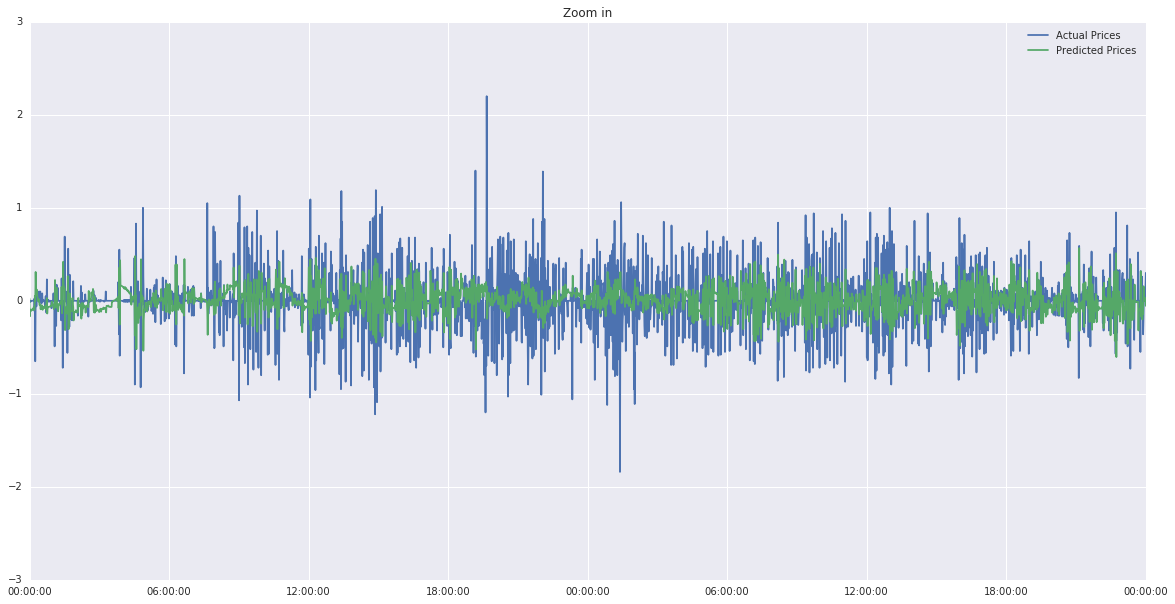

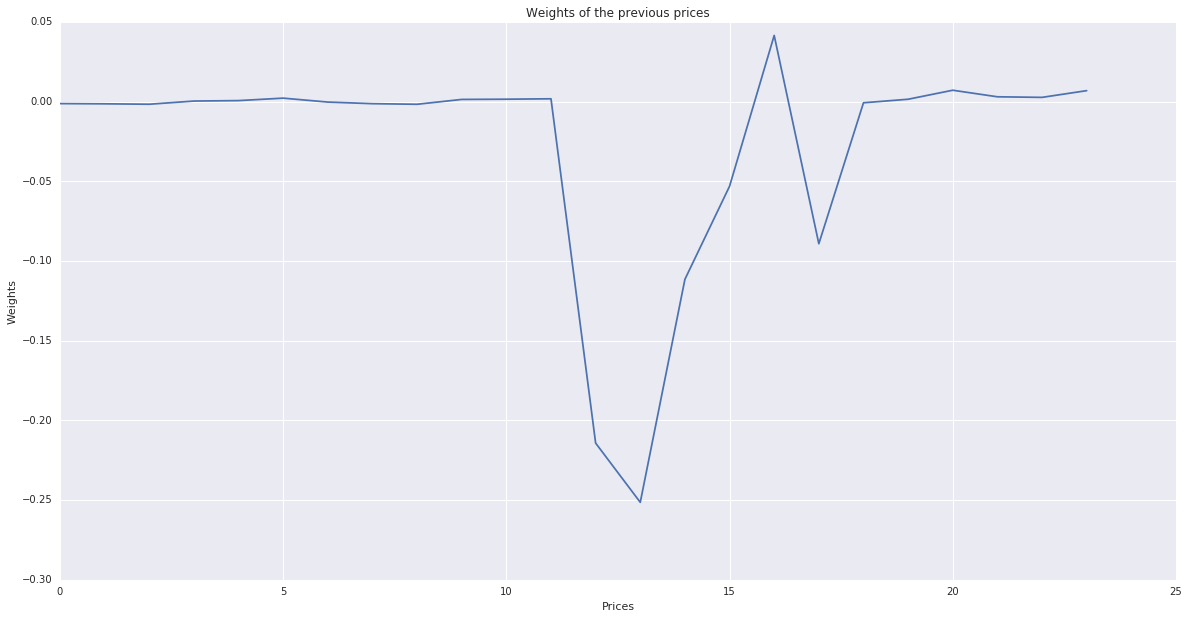

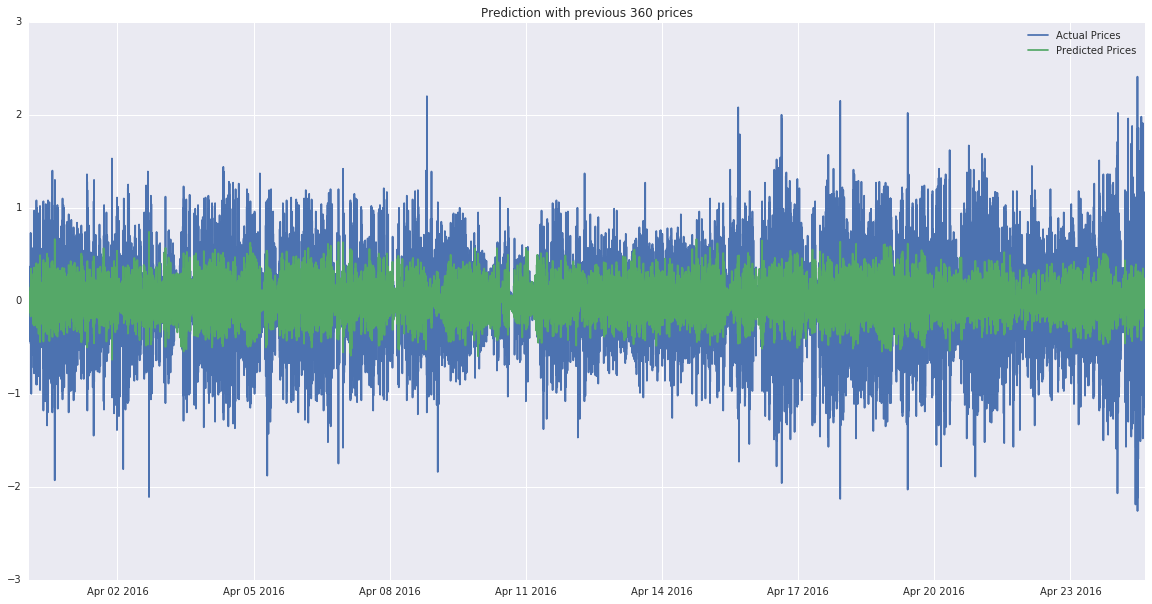

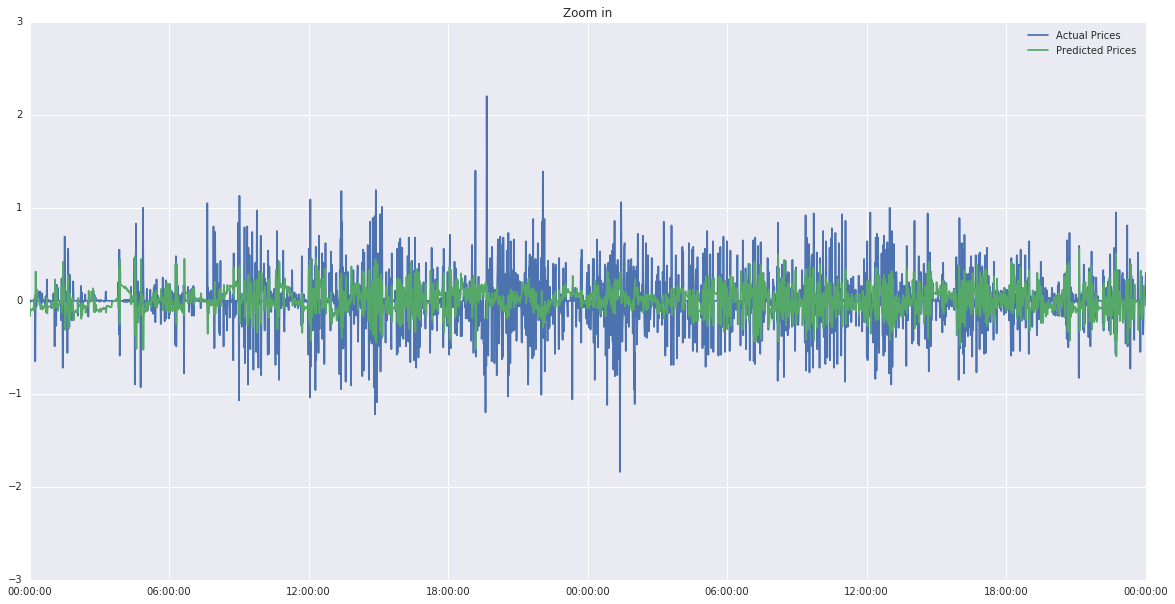

In [11]:
evaluate(data1m.copy())

First training date:  2016-02-05 15:49:38
Last training date:  2016-03-31 22:39:38
First testing date:  2016-03-31 22:44:38
Last testing date:  2016-04-24 15:24:38


Results of prediction with all the technical indicators

Training set R2:  0.0656536573058 , Test set R2:  0.118431804088
Training set RMSE:  0.607478361833 , Test set RMSE:  0.439271447107
Training set MAE:  0.408578357789 , Test set MAE:  0.310326775556
Directional Symmetry:  0.591648351648 



['K360', 'K180', 'K60', 'D360', 'D180', 'D60', 'sD360', 'sD60', 'MOM360', 'MOM180', 'MOM60', 'ROC360', 'ROC180', 'ROC60', 'LWR360', 'LWR180', 'LWR60', 'ADOSC360', 'ADOSC180', 'ADOSC60', 'DISP360', 'DISP180', 'DISP60', 'OSCP180-360', 'OSCP60-180', 'RSI360', 'RSI180', 'RSI60', 'CCI360', 'CCI180', 'CCI60'] 




Results of prediction with selected technical indicators

Training set R2:  0.0658656132114 , Test set R2:  0.117775750744
Training set RMSE:  0.607409454875 , Test set RMSE:  0.439434867196
Training set MAE:  0.408766649454 ,

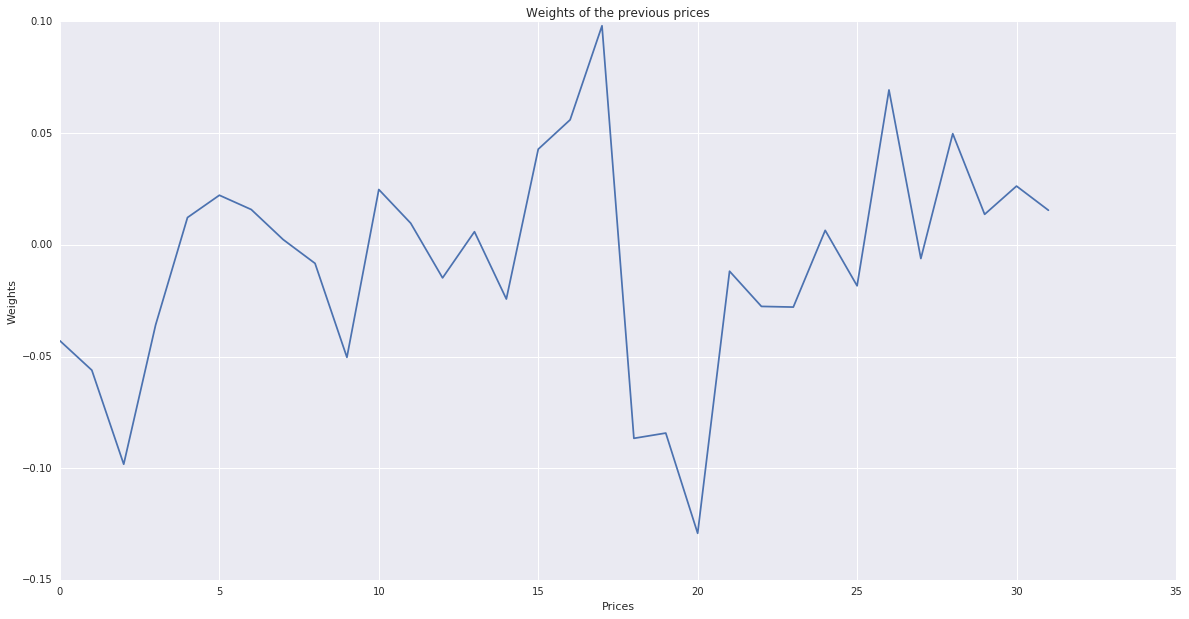

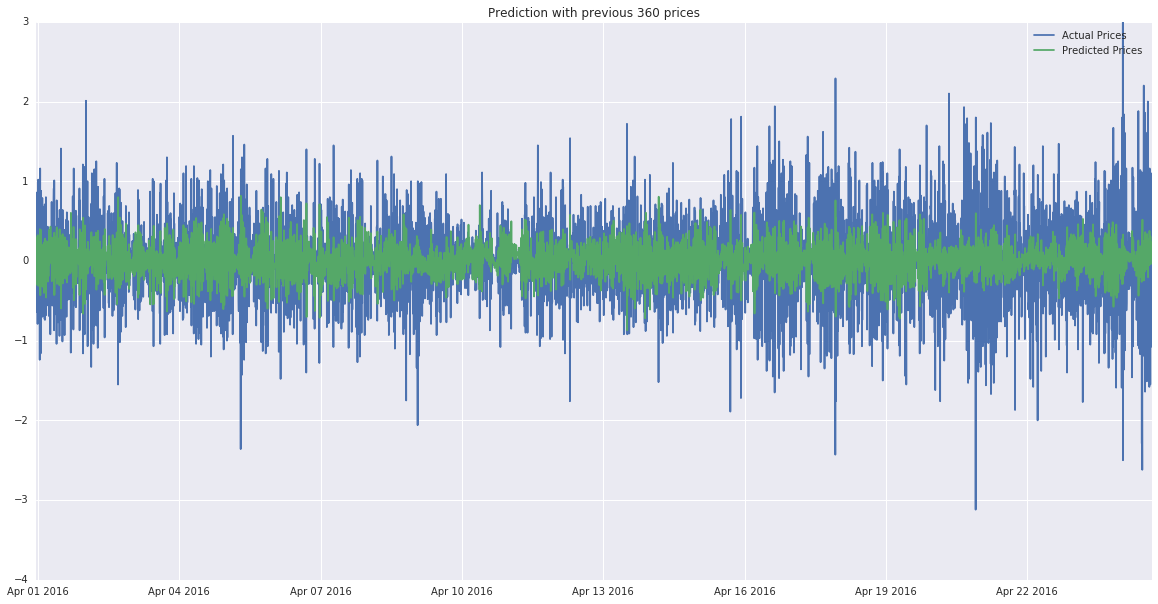

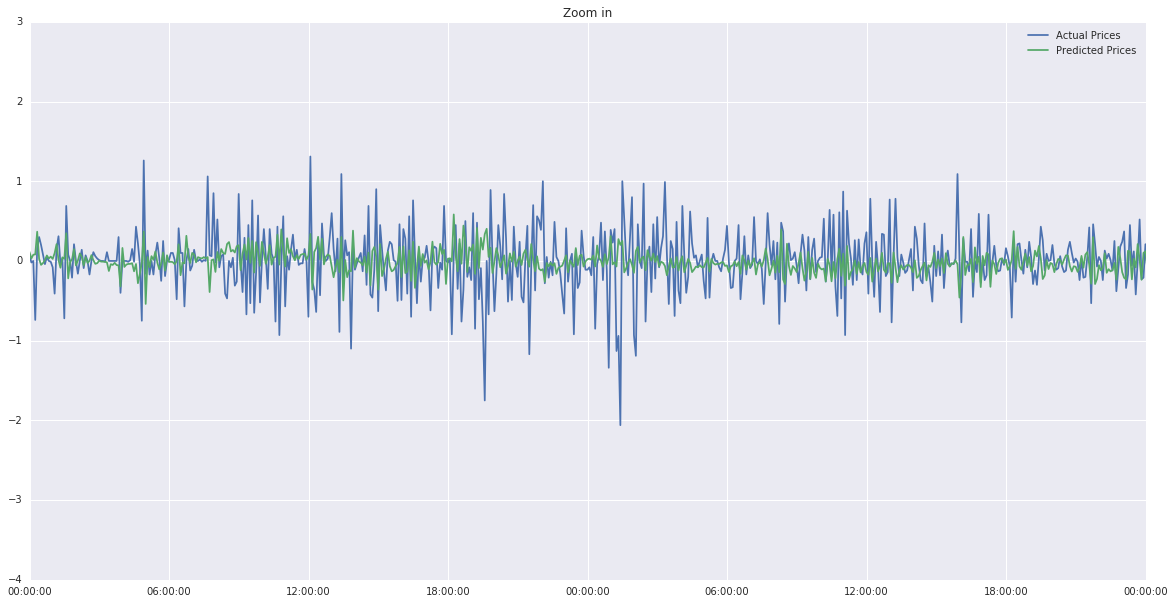

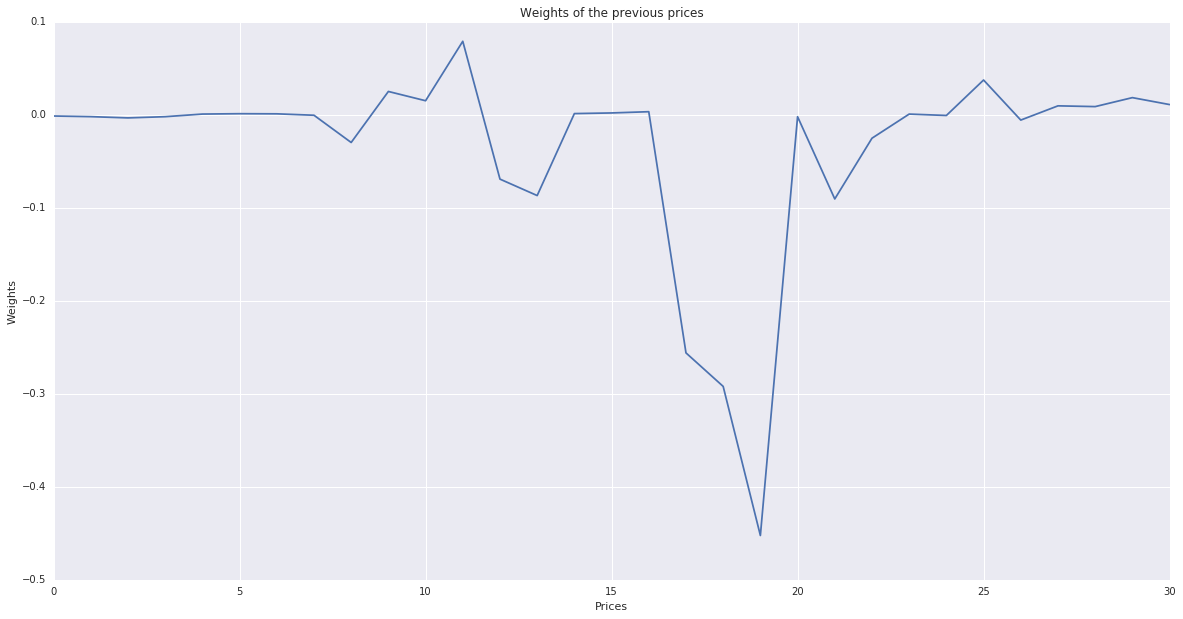

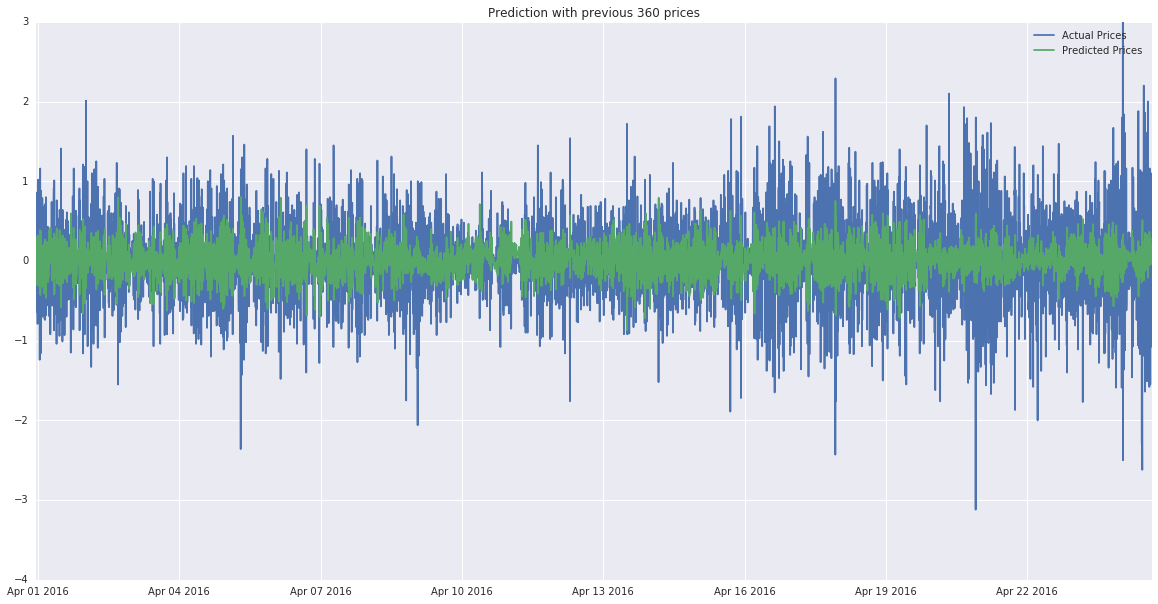

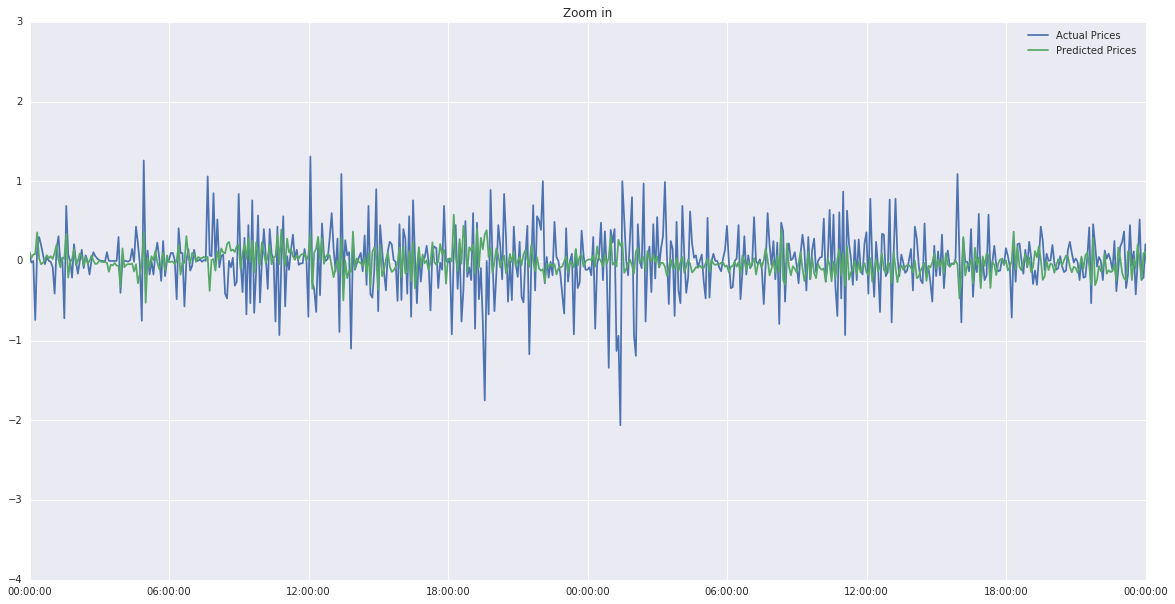

In [12]:
evaluate(data5m.copy())

First training date:  2016-02-09 09:30:38
Last training date:  2016-04-02 01:20:38
First testing date:  2016-04-02 01:30:38
Last testing date:  2016-04-24 15:10:38


Results of prediction with all the technical indicators

Training set R2:  0.0428774880734 , Test set R2:  0.0770958005587
Training set RMSE:  0.726321153213 , Test set RMSE:  0.507683118432
Training set MAE:  0.501267548121 , Test set MAE:  0.366282625091
Directional Symmetry:  0.581051984005 



['K360', 'K180', 'K60', 'D360', 'D180', 'D60', 'sD60', 'MOM360', 'MOM180', 'MOM60', 'ROC360', 'ROC180', 'ROC60', 'LWR360', 'LWR180', 'LWR60', 'ADOSC360', 'ADOSC180', 'ADOSC60', 'DISP360', 'DISP180', 'DISP60', 'OSCP180-360', 'OSCP60-180', 'RSI360', 'RSI180', 'RSI60', 'CCI180', 'CCI60'] 




Results of prediction with selected technical indicators

Training set R2:  0.0430320465413 , Test set R2:  0.0737692716499
Training set RMSE:  0.726262506793 , Test set RMSE:  0.508597245545
Training set MAE:  0.50156363698 , Test set MAE:  0.

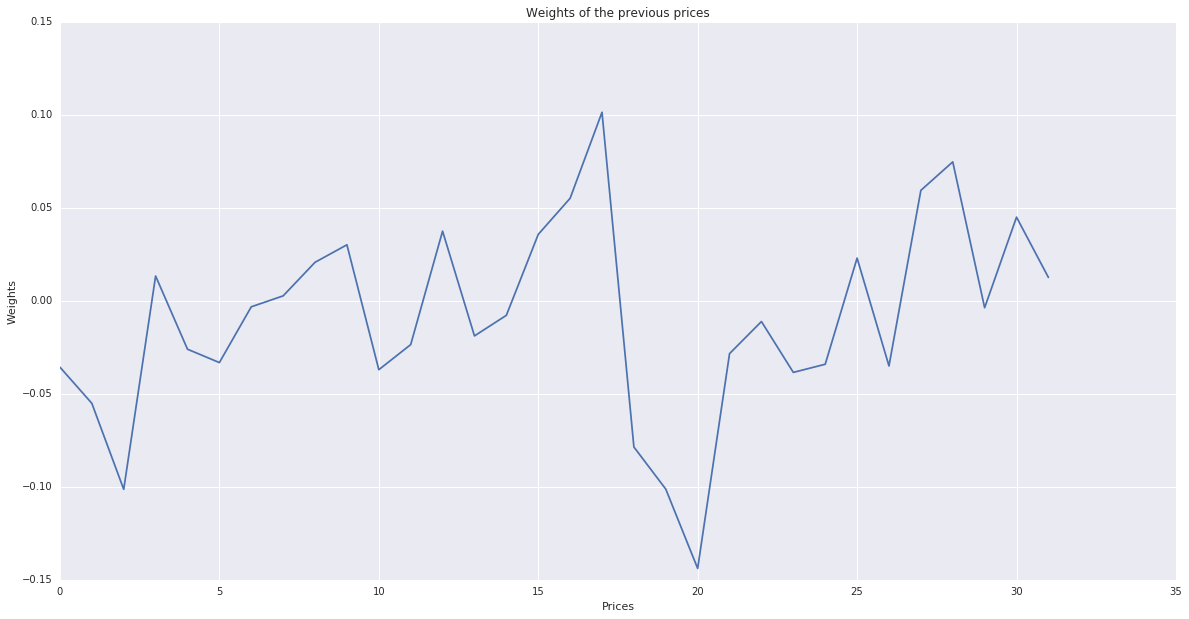

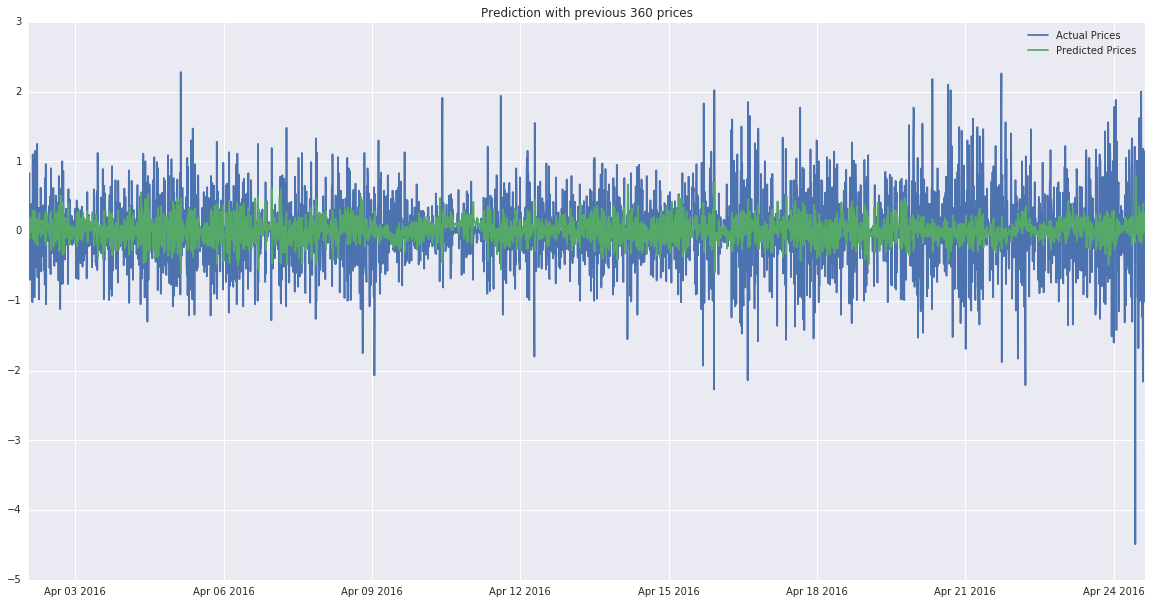

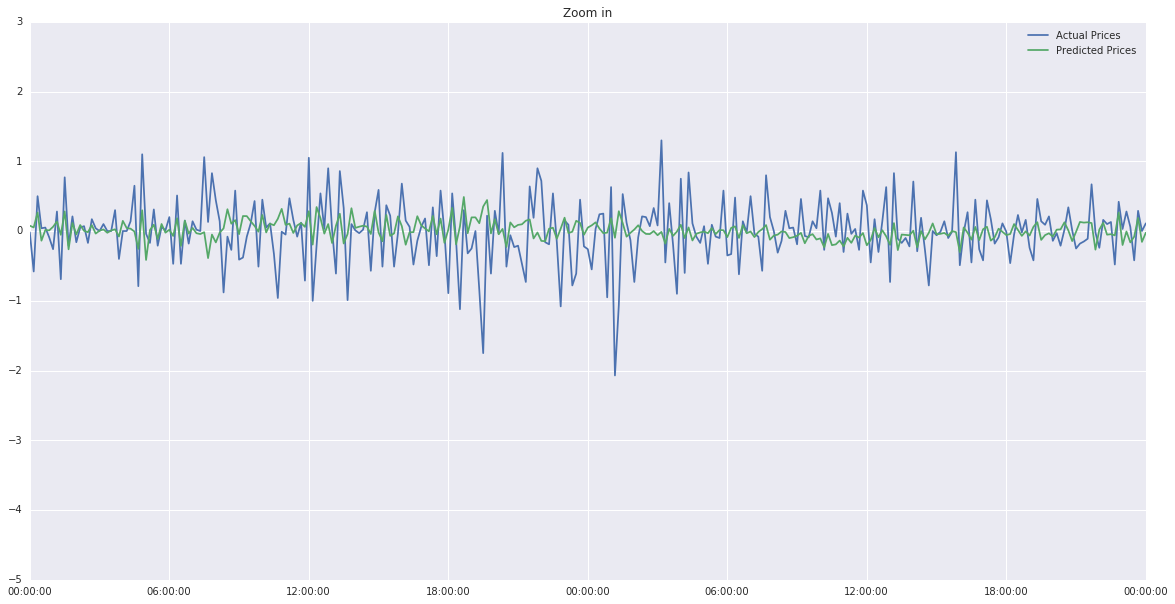

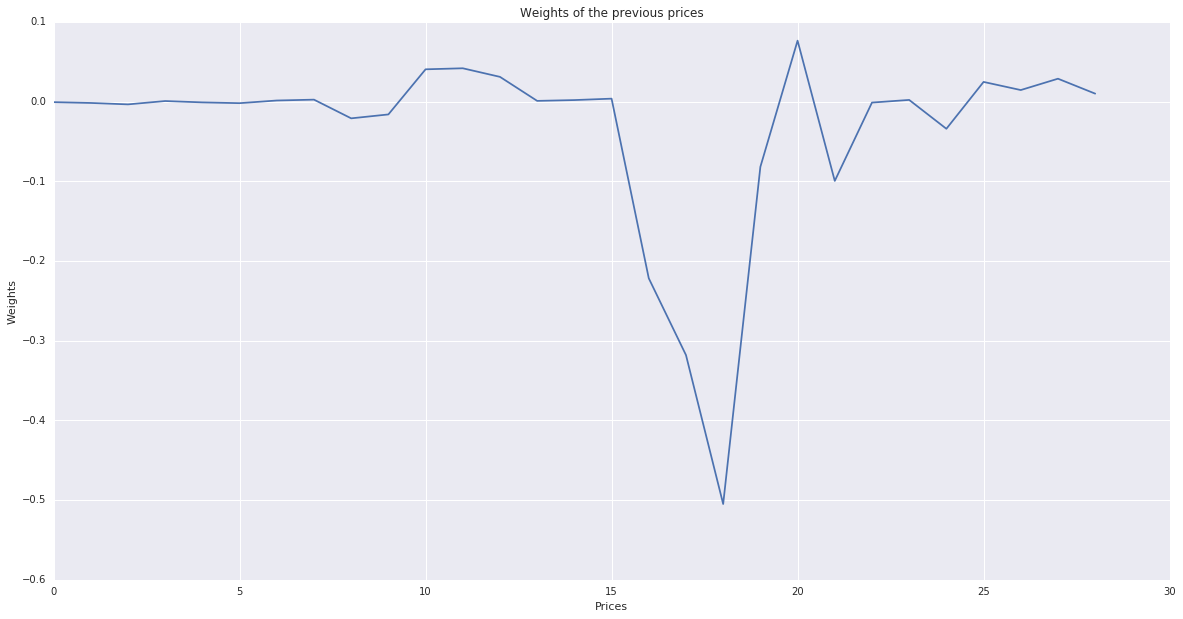

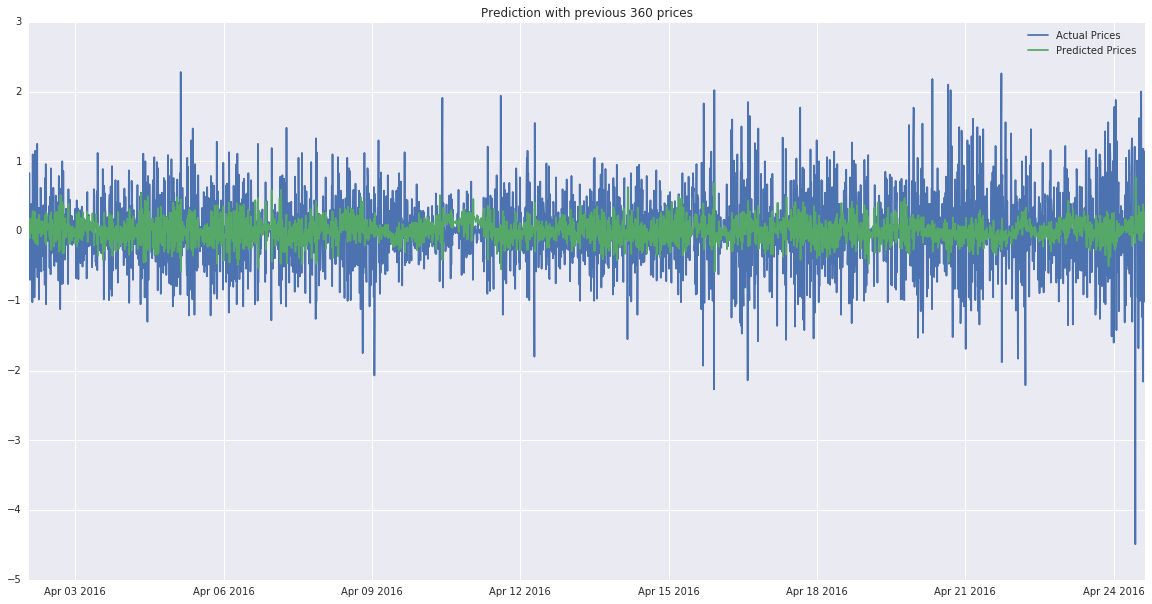

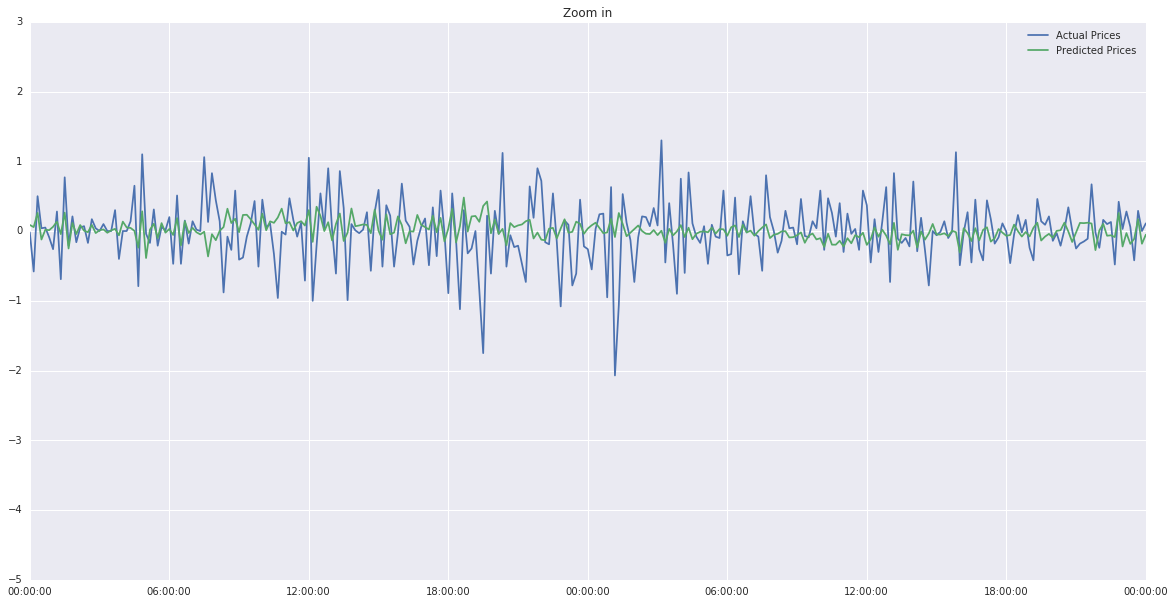

In [13]:
evaluate(data10m.copy())